In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, \
mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal
#!pip install statsmodels
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Реализация A/B Тестирования

In [3]:
df = pd.read_csv('F:/Рабочий стол/AB Test/AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Заметки:

- USER_ID: Идентификационный номер
- VARIANT_NAME: Група
- REVENUE: Доход

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,10000.0,4981.080200,2890.590115,2.0,2468.75,4962.0,7511.5,10000.00
REVENUE,10000.0,0.099447,2.318529,0.0,0.00,0.0,0.0,196.01


In [5]:
df.sort_values(by = 'REVENUE', ascending = False).head(15)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32
9125,831,control,25.98
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56


In [6]:
df = df[df['USER_ID'] != 3342]

In [7]:
df = df.groupby(by = ['USER_ID', 'VARIANT_NAME']).sum().reset_index()

In [8]:
df.duplicated().sum() # Проверка на дубликаты

0

In [9]:
df.drop_duplicates(inplace = True) # Сброс дубликатов

<Axes: xlabel='REVENUE', ylabel='Density'>

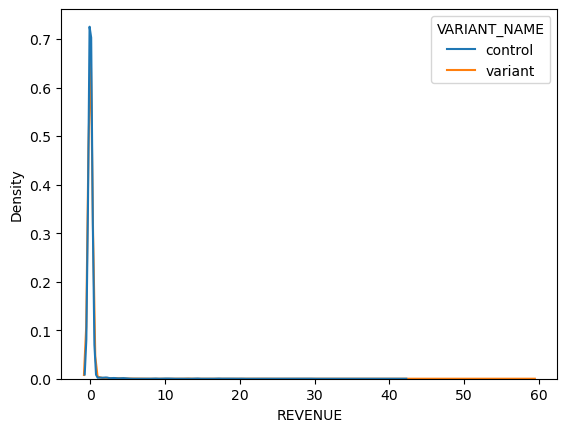

In [10]:
sns.kdeplot(data = df, x = 'REVENUE', hue = 'VARIANT_NAME')
# Проверека на нормальность распределения

In [11]:
def get_bootstrap_samples(data, n_samples = 1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


In [12]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [13]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 1000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 1000)


In [14]:
control = df[df['VARIANT_NAME'] == 'control']
variant = df[df['VARIANT_NAME'] == 'variant']

In [15]:
control.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,3930.0,4994.373791,2894.862727,2.0,2487.5,4974.0,7574.5,10000.00
REVENUE,3930.0,0.113738,1.304342,0.0,0.0,0.0,0.0,41.53


In [16]:
variant.describe().T

,count,mean,std,min,25%,50%,75%,max
USER_ID,3934.0,4961.772242,2887.055258,3.0,2439.75,4956.5,7415.75,10000.00
REVENUE,3934.0,0.089342,1.484566,0.0,0.00,0.0,0.00,58.63


### Проверка гипотез

In [17]:
control['REVENUE'].mean()

0.1137379134860051

In [18]:
variant['REVENUE'].mean()

0.08934163701067616

Заметки:
Согласно этим цифрам, кажется, что между группами может быть разница в доходах, но эта разница могла возникнуть случайно и должна быть статистически проверена

- Формулировка гипотез

    - H0: μ1 = μ2 (Статистической разницы в доходах между контрольной и вариантной группами нет)    
    - H1: μ1 ≠ μ2 (Существует статистическая разница между контрольной и вариантной группами с точки зрения выручки)

- Проверка гипотез

    - Предположение о нормальности
    - Однородность дисперсии
    
- Предположение о нормальности:

    - H0: Выполнено предположение о нормальном распределении
    - H1: Предположение о нормальном распределении не выполнено
    
- Предложение об однородности:

    - H0: Отклонения однородны
    - H1: Отклонения не однородны

### Нормальность распределения

In [19]:
test_stat, pvalue = shapiro(control['REVENUE'])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.0613, p-value = 0.0000


In [20]:
test_stat, pvalue = shapiro(variant['REVENUE'])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.0328, p-value = 0.0000


Заметки:
- Отклоняем H0, распределение не нормально
- Следовательно, нет необходимости проверять однородность отклонений. Мы можем перейти непосредственно к непараметрическому статистическому анализу, которым является тест Манна-Уитни."

### Non-parametric Test

In [21]:
test_stat, pvalue = mannwhitneyu(control['REVENUE'], variant['REVENUE'])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 7746585.5000, p-value = 0.4950


#### Согласно U-тесту Манна-Уитни, H0 не может быть отклонен. Существенной разницы между средними показателями этих двух групп нет.

---
# Fast Food Marketing Compaign A/B Testing

In [22]:
df2 = pd.read_csv('F:/Рабочий стол/AB Test/WA_Marketing-Campaign.csv')
df2.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


- MarketID: уникальный идентификатор рынка
- MarketSize: размер рыночной площади по продажам
- LocationID: уникальный идентификатор местоположения магазина
- AgeOfStore: возраст магазина в годах
- Promotion: одна из трех протестированных акций
- week: одна из четырех недель, когда проводились акции
- SalesInThousands: сумма продаж для определенного местоположения, рекламной акции и недели

In [23]:
df2['Promotion'].value_counts()

3    188
2    188
1    172
Name: Promotion, dtype: int64

In [24]:
promotion1 = df2[df2['Promotion'] == '1']
promotion2 = df2[df2['Promotion'] == '2']
promotion3 = df2[df2['Promotion'] == '3']

### Проверка гипотез

Заметки:
Согласно этим цифрам, кажется, что может быть разница в типах рекламных акций, но эта разница могла возникнуть случайно и должна быть проверена статистически.

- Формулировка гипотез:
    - H0: μ1 = μ2 = μ3 (статистической разницы в типах рекламных акций нет)
    - H1: По крайней мере, одна группа отличается от других
    
- Проверка предположений:
    - Нормальность распределения
    - Однородность дисперсии
    
- Предположение о нормальности:
    - H0: Выполнено предположение о нормальном распределении
    - H1: Предположение о нормальном распределении не выполнено
    
- Предположение об однородности дисперсии:
    - H0: Отклонения однороды
    - H1: Отклонения неоднородны

### Нормальность распределения

In [25]:
for group in list(df2['Promotion'].unique()):
    
    pvalue = shapiro(df2.loc[df2['Promotion'] == group, 'SalesInThousands'])[1]
    
    print(group, 'p-value: %.4f' % pvalue)

3 p-value: 0.0000
2 p-value: 0.0000
1 p-value: 0.0000


Заметки:

- Отклоняем нулевую гипотезу. Распределение ненормально
- Следовательно, нет необходимости проверять однородность отклонений. Мы можем перейти непосредственно к непараметрическому статистическому анализу, которым является тест Крускала.

### Non-parametric Test

In [26]:
s, p = kruskal(df2.loc[df2['Promotion'] == 1, 'SalesInThousands'],
              df2.loc[df2['Promotion'] == 2, 'SalesInThousands'],
              df2.loc[df2['Promotion'] == 3, 'SalesInThousands'])

print(f'\nStatistic: {s:.3f}\np-Value: {p:.3f}\n')


Statistic: 53.295
p-Value: 0.000



Значение p для гипотезы о равенстве рекламных акций меньше 0,05; следовательно, мы отвергаем нулевую гипотезу, указывая на то, что гипотеза о равенстве не выполняется

In [27]:
from statsmodels.stats.multicomp import MultiComparison

comparison = MultiComparison(df2['SalesInThousands'], df2['Promotion'])
tukey = comparison.tukeyhsd(0.05)

print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


Как было замечено, мы не можем отвергнуть сходство между 1 и 3, между 1 и 3 была обнаружена разница

---
# Mobile Games A/B Testing

In [28]:
df3 = pd.read_csv('F:/Рабочий стол/AB Test/cookie_cats.csv')
df3.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Заметки:
- userid: уникальный идентификатор для каждого пользователя.
- version: Версия игры (например, Gate_30 или Gate_40).
- sum_gamerounds: Общее количество раундов игры, сыгранных пользователем.
- retention_1: Сохранился ли пользователь через 1 день после установки (1 - сохранился, 0 - не сохранился).
- retention_7: Сохранился ли пользователь после 7 дней с момента установки (1 - сохранился, 0 - не сохранился).

In [29]:
df3.shape

(90189, 5)

In [30]:
df2.duplicated().sum()

0

In [31]:
sms.DescrStatsW(df3['sum_gamerounds']).tconfint_mean()
# Проверили доверительные интервалы перед отбором проб

(50.59946671311376, 53.14544674639904)

In [32]:
sample = df3.sample(n = 5000, random_state = 42)
sample['sum_gamerounds'].mean()

51.9722

Заметки:
- Тест Шапиро-Уилка требует, чтобы размер выборки был меньше 5000. Следовательно, для каждого уникального значения "версии" мы отобрали 2500 единиц выборки, присвоив n=5000.
- Мы можем использовать выборочное среднее значение, поскольку оно попадает в доверительный интервал всего нашего набора данных.

### Проверка гипотез

In [33]:
sample.groupby('version').agg({'sum_gamerounds': ['count', 'mean']})

sum_gamerounds           
                 count       mean
version                          
gate_30           2503  52.296444
gate_40           2497  51.647177

Заметки:
Согласно этим цифрам, кажется, что в игровых раундах может быть разница, но эта разница могла возникнуть случайно и должна быть проверена статистически.

- Формулировка гипотез
    - H0: μ1 = μ2 (Статистической разницы в количестве сыгранных раундов игры между версиями нет)
    - H1: μ1 ≠ μ2 (Существует статистическая разница в количестве сыгранных раундов игры между версиями)
    
- Проверка предположений:
    - Нормальность распределения
    - Однородность дисперсии

- Проверка на нормальность распределения:
    - H0: Предположение о нормальности распределения выполнено
    - H1: Предположение о нормальности распределения не выполнено 
    
- Предположение об однородности дисперсии:
    - H0: Дисперсии однородны
    - H1: Дисперсии не однородны

### Нормальность распределения

In [34]:
for gate in sample['version'].unique():
    
    s,p = shapiro(sample.loc[sample['version'] == gate, 'sum_gamerounds'])
    
    print(f'Version: {gate} \nStatistic: {s:.3f}\np-Value: {p:.3f}\n')

Version: gate_30 
Statistic: 0.468
p-Value: 0.000

Version: gate_40 
Statistic: 0.494
p-Value: 0.000



- Отклояняем нулевую гипотезу. Распределение не нормально.
- Следовательно, нет необходимости проверять однородность отклонений. Мы можем перейти непосредственно к непараметрическому статистическому анализу, которым является тест Манна-Уитни"

### Non-parametric Test

In [35]:
s, p = mannwhitneyu(sample.loc[sample['version'] == 'gate_30', 'sum_gamerounds'],
                   sample.loc[sample['version'] == 'gate_40', 'sum_gamerounds'])

print(f'\nStatistic: {s:.3f}\np-Value: {p:.3f}\n')


Statistic: 3120414.500
p-Value: 0.928



Согласно U-критерию Манна-Уитни, нулевая гипотеза не может быть отклонена. Существенной разницы между средними показателями этих двух групп нет.